## Individual Risk Assessment
### Data Science and AI Risk Management Industry Group

This notebook serves to assess the impact of individualised driver telematics data on a policyholder's risk premium, by considering 3 categories:
1. Course grouping using common characteristics associated with pricing
2. More granular grouping using additional features
3. Individual pricing which takes into account driver telematics

The aim is to assess whether additional risks are present when moving from pricing based on risk-pooling to individual risk assessment.

This investigation will also consider Gender as a protected feature and thus exclude it as a factor.

### 0. Loading Libraries, Data, and Feature Encoding

In [74]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
import lime
import lime.lime_tabular
import shap

In [75]:
data = pd.read_csv("../data/telematics_syn-032021.csv")
data.head()

Duration  Insured.age Insured.sex  Car.age  Marital  Car.use  Credit.score  \
0       366           45        Male       -1  Married  Commute         609.0   
1       182           44      Female        3  Married  Commute         575.0   
2       184           48      Female        6  Married  Commute         847.0   
3       183           71        Male        6  Married  Private         842.0   
4       183           84        Male       10  Married  Private         856.0   

  Region  Annual.miles.drive  Years.noclaims  ...  Left.turn.intensity10  \
0  Urban             6213.71              25  ...                    1.0   
1  Urban            12427.42              20  ...                   58.0   
2  Urban            12427.42              14  ...                    0.0   
3  Urban             6213.71              43  ...                    0.0   
4  Urban             6213.71              65  ...                    2.0   

   Left.turn.intensity11  Left.turn.intensity12  Right.turn.intensity08  \
0                    0.0                    0.0                     3.0   
1                   24.0                   11.0                  1099.0   
2                    0.0                    0.0                     0.0   
3                    0.0                    0.0                     0.0   
4                    0.0                    0.0                   325.0   

   Right.turn.intensity09  Right.turn.intensity10  Right.turn.intensity11  \
0                     1.0                     0.0                     0.0   
1                   615.0                   219.0                   101.0   
2                     0.0                     0.0                     0.0   
3                     0.0                     0.0                     0.0   
4                   111.0                    18.0                     4.0   

   Right.turn.intensity12  NB_Claim    AMT_Claim  
0                     0.0         1  5100.171753  
1                    40.0         1   883.554840  
2                     0.0         0     0.000000  
3                     0.0         0     0.000000  
4                     2.0         0     0.000000  

[5 rows x 52 columns]

In [76]:
data = pd.get_dummies(data, drop_first=True)

In [77]:
data.head()

Duration  Insured.age  Car.age  Credit.score  Annual.miles.drive  \
0       366           45       -1         609.0             6213.71   
1       182           44        3         575.0            12427.42   
2       184           48        6         847.0            12427.42   
3       183           71        6         842.0             6213.71   
4       183           84       10         856.0             6213.71   

   Years.noclaims  Territory  Annual.pct.driven  Total.miles.driven  \
0              25         70           0.849315         8864.376247   
1              20         26           0.465753         8092.308208   
2              14         84           0.520548         3225.832512   
3              43         30           0.065753          253.024528   
4              65         70           0.441096         4374.379634   

   Pct.drive.mon  ...  Right.turn.intensity11  Right.turn.intensity12  \
0       0.148070  ...                     0.0                     0.0   
1       0.147686  ...                   101.0                    40.0   
2       0.153735  ...                     0.0                     0.0   
3       0.106702  ...                     0.0                     0.0   
4       0.123807  ...                     4.0                     2.0   

   NB_Claim    AMT_Claim  Insured.sex_Male  Marital_Single  Car.use_Commute  \
0         1  5100.171753                 1               0                1   
1         1   883.554840                 0               0                1   
2         0     0.000000                 0               0                1   
3         0     0.000000                 1               0                0   
4         0     0.000000                 1               0                0   

   Car.use_Farmer  Car.use_Private  Region_Urban  
0               0                0             1  
1               0                0             1  
2               0                0             1  
3               0                1             1  
4               0                1             1  

[5 rows x 54 columns]

We drop `Insured.sex_Male` as a feature:

In [78]:
data.drop(['Insured.sex_Male'], inplace=True, axis=1)

We can proceed to create our 3 groups:
1. Group A considers the following factors: `Duration`, `Insured.age`, `Car.age`, `Years.noclaims`, `Marital_Single`, `Car.use`
2. Group B considers the following factors in addition to Group 1's: `Credit.score`, `Annual.miles.drive`, `Territory`, `Region`
3. Group C considers the following factors in addition to Group 2's: `Annual.pct.driven`, `Total.miles.driven`, `Pct.drive.xxx`, `Pct.drive.xhrs`, `Pct.drive.rushxx`, `Avgdays.week`, `Accel.xxmiles`, `Brake.xxmiles`, `Left.turn.intensityxx`, `Right.turn.intensityxx`

In [79]:
group_A = data[['Duration', 'Insured.age', 'Car.age', 'Years.noclaims', 'Marital_Single', 'Car.use_Commute', 'Car.use_Farmer', 'Car.use_Private', 'Region_Urban', 'AMT_Claim']]
group_B = data[['Duration', 'Insured.age', 'Car.age', 'Years.noclaims', 'Marital_Single', 'Car.use_Commute', 'Car.use_Farmer', 'Car.use_Private', 'Region_Urban', 'Credit.score', 'Annual.miles.drive', 'Territory', 'AMT_Claim']]
group_C = data.drop(['NB_Claim'], axis=1)

### 1. Group A: Standard Pricing Factors

#### 1.1 Data Management and Preliminary Analysis

In [80]:
group_A_y = group_A['AMT_Claim']
group_A_X = group_A.drop(['AMT_Claim', 'Region_Urban'], axis=1)

In [81]:
group_A_X

Duration  Insured.age  Car.age  Years.noclaims  Marital_Single  \
0           366           45       -1              25               0   
1           182           44        3              20               0   
2           184           48        6              14               0   
3           183           71        6              43               0   
4           183           84       10              65               0   
...         ...          ...      ...             ...             ...   
99995       182           61       10              42               1   
99996       192           48        3              32               0   
99997       184           50        2              31               1   
99998       184           76        2              58               0   
99999       365           25        2               7               1   

       Car.use_Commute  Car.use_Farmer  Car.use_Private  
0                    1               0                0  
1                    1               0                0  
2                    1               0                0  
3                    0               0                1  
4                    0               0                1  
...                ...             ...              ...  
99995                0               0                1  
99996                1               0                0  
99997                1               0                0  
99998                0               0                1  
99999                0               0                0  

[100000 rows x 8 columns]

We apply bucketing to `Duration`, `Insured.age`, `Years.noclaims` to make coarser risk groupings:

The Farmer car use is sparse, so we can exclude it and therefore incorporate it as part of the baseline.

In [82]:
group_A_X.drop(['Car.use_Farmer'], axis=1, inplace=True)

<Axes: xlabel='Duration', ylabel='Count'>

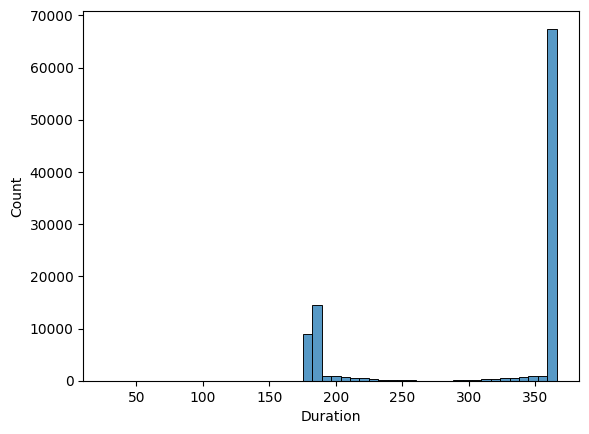

In [83]:
sns.histplot(group_A_X['Duration'])

We can group `Duration` into two categories: $<200$ and $\ge200$. 

In [84]:
group_A_X['Duration'] = pd.cut(group_A_X['Duration'], bins=[0, 183, 366], labels=["0-183", "184-366"])

<Axes: xlabel='Insured.age', ylabel='Count'>

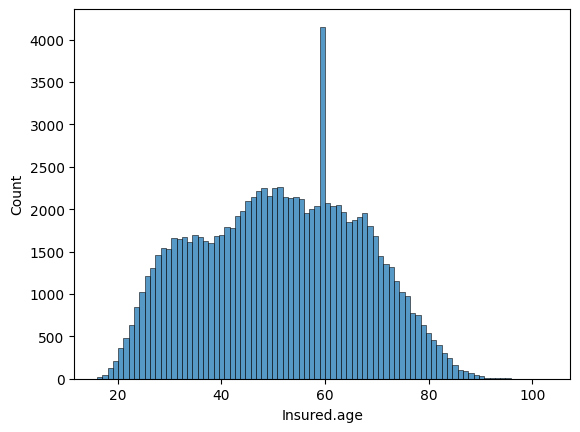

In [85]:
sns.histplot(group_A_X['Insured.age'])

Similarly, we can bucket age as follows: $<25$, $25-44$, $45-59$, $\ge60$

In [86]:
group_A_X['Insured.age'] = pd.cut(group_A_X['Insured.age'], bins=[0, 24, 49, 110], labels=["0-24", "25-49", "50+"])

<Axes: xlabel='Years.noclaims', ylabel='Count'>

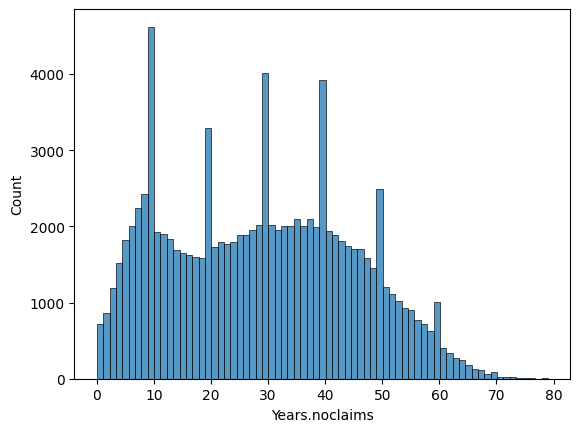

In [87]:
sns.histplot(group_A_X['Years.noclaims'])

No claim years can be grouped as follows: $<10$, $10-19$, $20-29$, $30-39$, $40-49$, $\ge50$

In [88]:
group_A_X['Years.noclaims'] = pd.cut(group_A_X['Years.noclaims'], bins=[0, 19, 81], labels=["0-9", "10+"])

We can perform a final bucketing based on vehicle age, as shown below:

<Axes: xlabel='Car.age', ylabel='Count'>

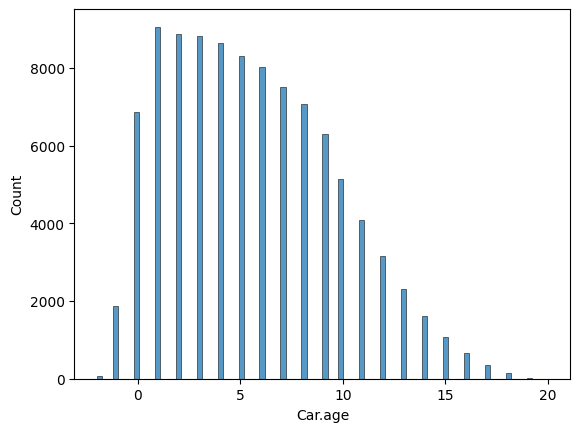

In [89]:
sns.histplot(group_A_X['Car.age'])

Note that negative values represent cars purchased in advance of their release. We bucket the car ages as follows: $<1$, $1-3$, $4-6$, $7-10$, $\ge11$

In [90]:
group_A_X['Car.age'] = pd.cut(group_A_X['Car.age'], bins=[-2, 1, 5, 20], labels=["new", "1-5", "6+"])

We now convert the categorical features we created into dummy variables, dropping the first as a base line.

In [91]:
group_A_X = pd.get_dummies(group_A_X, drop_first=True)

In [92]:
group_A_X

Marital_Single  Car.use_Commute  Car.use_Private  Duration_184-366  \
0                   0                1                0                 1   
1                   0                1                0                 0   
2                   0                1                0                 1   
3                   0                0                1                 0   
4                   0                0                1                 0   
...               ...              ...              ...               ...   
99995               1                0                1                 0   
99996               0                1                0                 1   
99997               1                1                0                 1   
99998               0                0                1                 1   
99999               1                0                0                 1   

       Insured.age_25-49  Insured.age_50+  Car.age_1-5  Car.age_6+  \
0                      1                0            0           0   
1                      1                0            1           0   
2                      1                0            0           1   
3                      0                1            0           1   
4                      0                1            0           1   
...                  ...              ...          ...         ...   
99995                  0                1            0           1   
99996                  1                0            1           0   
99997                  0                1            1           0   
99998                  0                1            1           0   
99999                  1                0            1           0   

       Years.noclaims_10+  
0                       1  
1                       1  
2                       0  
3                       1  
4                       1  
...                   ...  
99995                   1  
99996                   1  
99997                   1  
99998                   1  
99999                   0  

[100000 rows x 9 columns]

The number of unique risk groups are as follows:

In [93]:
exposure_size = group_A_X.groupby(group_A_X.columns.tolist(),as_index=False).size()

In [94]:
exposure_size

Marital_Single  Car.use_Commute  Car.use_Private  Duration_184-366  \
0                 0                0                0                 0   
1                 0                0                0                 0   
2                 0                0                0                 0   
3                 0                0                0                 0   
4                 0                0                0                 0   
..              ...              ...              ...               ...   
163               1                1                0                 1   
164               1                1                0                 1   
165               1                1                0                 1   
166               1                1                0                 1   
167               1                1                0                 1   

     Insured.age_25-49  Insured.age_50+  Car.age_1-5  Car.age_6+  \
0                    0                1            0           0   
1                    0                1            0           0   
2                    0                1            0           1   
3                    0                1            0           1   
4                    0                1            1           0   
..                 ...              ...          ...         ...   
163                  1                0            0           0   
164                  1                0            0           1   
165                  1                0            0           1   
166                  1                0            1           0   
167                  1                0            1           0   

     Years.noclaims_10+  size  
0                     0     8  
1                     1   108  
2                     0     7  
3                     1   325  
4                     0    13  
..                  ...   ...  
163                   1   573  
164                   0  3862  
165                   1  1280  
166                   0  2818  
167                   1  1141  

[168 rows x 10 columns]

In [95]:
len(exposure_size)

168

In [96]:
exposure_size.describe()

Marital_Single  Car.use_Commute  Car.use_Private  Duration_184-366  \
count      168.000000       168.000000       168.000000        168.000000   
mean         0.517857         0.357143         0.339286          0.523810   
std          0.501175         0.480590         0.474882          0.500926   
min          0.000000         0.000000         0.000000          0.000000   
25%          0.000000         0.000000         0.000000          0.000000   
50%          1.000000         0.000000         0.000000          1.000000   
75%          1.000000         1.000000         1.000000          1.000000   
max          1.000000         1.000000         1.000000          1.000000   

       Insured.age_25-49  Insured.age_50+  Car.age_1-5  Car.age_6+  \
count         168.000000       168.000000   168.000000  168.000000   
mean            0.416667         0.428571     0.333333    0.339286   
std             0.494481         0.496351     0.472814    0.474882   
min             0.000000         0.000000     0.000000    0.000000   
25%             0.000000         0.000000     0.000000    0.000000   
50%             0.000000         0.000000     0.000000    0.000000   
75%             1.000000         1.000000     1.000000    1.000000   
max             1.000000         1.000000     1.000000    1.000000   

       Years.noclaims_10+         size  
count          168.000000   168.000000  
mean             0.428571   595.238095  
std              0.496351  1205.327661  
min              0.000000     1.000000  
25%              0.000000    30.500000  
50%              0.000000   108.000000  
75%              1.000000   506.500000  
max              1.000000  8855.000000

<Axes: xlabel='size', ylabel='Count'>

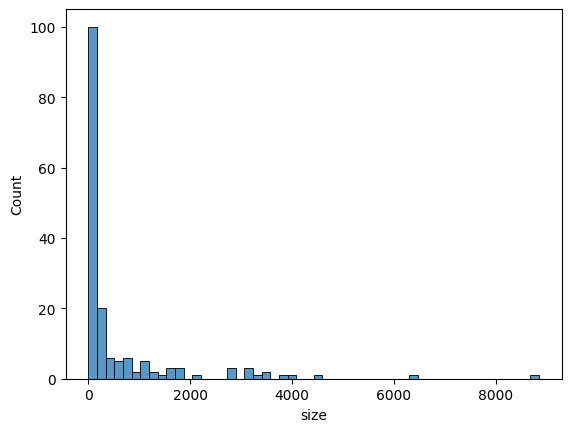

In [97]:
sns.histplot(exposure_size['size'])

#### 1.2 Model Building and Predictions

In [98]:
group_A_X_train, group_A_X_test, group_A_y_train, group_A_y_test = train_test_split(group_A_X, group_A_y, train_size=0.7, random_state=1)
group_A_model = HistGradientBoostingRegressor(max_iter=1000, l2_regularization=True, random_state=1, verbose=0, early_stopping=True)
group_A_model.fit(group_A_X_train, group_A_y_train)
group_A_y_pred = group_A_model.predict(group_A_X_test)
group_A_final = group_A_X_test
group_A_final["risk_premium"] = group_A_y_pred
group_A_final["actual_claim"] = group_A_y_test
group_A_final['risk_premium'].describe()

count    30000.000000
mean       140.430545
std        110.825596
min          7.756431
25%         63.503263
50%        120.984537
75%        184.994142
max       1057.085991
Name: risk_premium, dtype: float64

In [99]:
group_A_final.sort_values(by=["risk_premium"], ascending=False)

Marital_Single  Car.use_Commute  Car.use_Private  Duration_184-366  \
51406               1                0                1                 1   
58676               1                0                1                 1   
64852               1                0                1                 1   
62989               1                0                1                 1   
55157               1                0                1                 1   
...               ...              ...              ...               ...   
38795               1                1                0                 0   
19009               1                1                0                 0   
36919               1                1                0                 0   
8198                1                1                0                 0   
65784               1                1                0                 0   

       Insured.age_25-49  Insured.age_50+  Car.age_1-5  Car.age_6+  \
51406                  0                0            0           0   
58676                  0                0            0           0   
64852                  0                0            0           0   
62989                  0                0            0           0   
55157                  0                0            0           0   
...                  ...              ...          ...         ...   
38795                  0                0            1           0   
19009                  0                0            1           0   
36919                  0                0            1           0   
8198                   0                0            1           0   
65784                  0                0            1           0   

       Years.noclaims_10+  risk_premium  actual_claim  
51406                   0   1057.085991           0.0  
58676                   0   1057.085991           0.0  
64852                   0   1057.085991           0.0  
62989                   0   1057.085991           0.0  
55157                   0   1057.085991           0.0  
...                   ...           ...           ...  
38795                   0      7.756431           0.0  
19009                   0      7.756431           0.0  
36919                   0      7.756431           0.0  
8198                    0      7.756431           0.0  
65784                   0      7.756431           0.0  

[30000 rows x 11 columns]

In [100]:
group_A_X_train, group_A_X_test, group_A_y_train, group_A_y_test = train_test_split(group_A_X, group_A_y, train_size=0.7, random_state=1)
group_A_model = AdaBoostRegressor(n_estimators=1000, random_state=1)
group_A_model.fit(group_A_X_train, group_A_y_train)
group_A_y_pred = group_A_model.predict(group_A_X_test)
group_A_final = group_A_X_test
group_A_final["risk_premium"] = group_A_y_pred
group_A_final["actual_claim"] = group_A_y_test
group_A_final['risk_premium'].describe()

count    30000.000000
mean       622.802302
std       1735.153950
min          8.911580
25%        149.816238
50%        180.472711
75%        368.494826
max      10504.873628
Name: risk_premium, dtype: float64

In [101]:
group_A_X_train, group_A_X_test, group_A_y_train, group_A_y_test = train_test_split(group_A_X, group_A_y, train_size=0.7, random_state=1)
group_A_X_test_copy  = group_A_X_test.copy()

In [102]:
group_A_model = RandomForestRegressor(n_estimators=5000, n_jobs=12)
group_A_model.fit(group_A_X_train, group_A_y_train)

RandomForestRegressor(n_estimators=5000, n_jobs=12)

In [103]:
group_A_y_pred = group_A_model.predict(group_A_X_test)

In [104]:
group_A_final = group_A_X_test

In [105]:
group_A_final["risk_premium"] = group_A_y_pred
group_A_final["actual_claim"] = group_A_y_test

In [106]:
group_A_final

Marital_Single  Car.use_Commute  Car.use_Private  Duration_184-366  \
43660               0                0                1                 0   
87278               0                0                1                 1   
14317               0                0                1                 1   
81932               0                0                1                 0   
95321               1                0                1                 1   
...               ...              ...              ...               ...   
994                 0                1                0                 1   
42287               0                0                1                 1   
4967                1                1                0                 1   
47725               0                0                1                 1   
42348               0                1                0                 1   

       Insured.age_25-49  Insured.age_50+  Car.age_1-5  Car.age_6+  \
43660                  0                1            0           1   
87278                  0                1            0           1   
14317                  0                1            0           1   
81932                  1                0            0           0   
95321                  0                1            0           1   
...                  ...              ...          ...         ...   
994                    0                1            0           1   
42287                  1                0            0           0   
4967                   1                0            1           0   
47725                  0                1            0           1   
42348                  0                1            0           1   

       Years.noclaims_10+  risk_premium  actual_claim  
43660                   0     35.334413      0.000000  
87278                   1     63.094034      0.000000  
14317                   1     63.094034      0.000000  
81932                   1      0.000000      0.000000  
95321                   1     72.866797      0.000000  
...                   ...           ...           ...  
994                     0    195.793883      0.000000  
42287                   0    344.337074      0.000000  
4967                    0    251.231502      0.000000  
47725                   1     63.094034    114.529449  
42348                   1     85.907407      0.000000  

[30000 rows x 11 columns]

In [107]:
group_A_final['risk_premium'].describe()

count    30000.000000
mean       140.923360
std        121.266337
min          0.000000
25%         63.094034
50%        125.567479
75%        182.755798
max       1536.885698
Name: risk_premium, dtype: float64

<Axes: xlabel='risk_premium', ylabel='Count'>

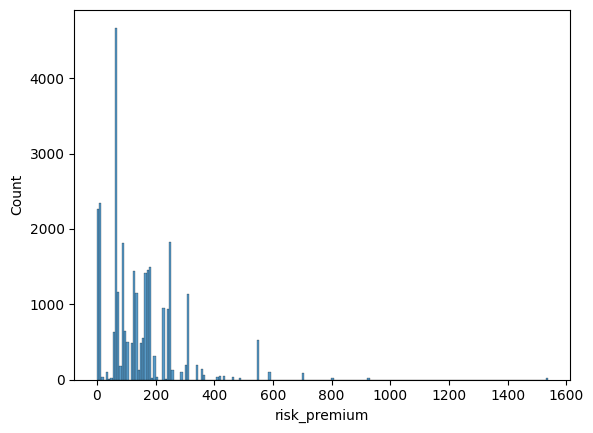

In [108]:
sns.histplot(group_A_final["risk_premium"])

In [109]:
mean_absolute_error(group_A_y_pred, group_A_y_test)

253.86169399875763

In [110]:
group_A_final.sort_values(by=["risk_premium"], ascending=False)

Marital_Single  Car.use_Commute  Car.use_Private  Duration_184-366  \
38056               1                0                1                 1   
6317                1                0                1                 1   
6210                1                0                1                 1   
84071               1                0                1                 1   
62989               1                0                1                 1   
...               ...              ...              ...               ...   
23310               1                0                1                 0   
73107               0                0                0                 0   
2000                0                0                0                 0   
10490               1                0                0                 1   
90197               0                0                1                 0   

       Insured.age_25-49  Insured.age_50+  Car.age_1-5  Car.age_6+  \
38056                  0                0            0           0   
6317                   0                0            0           0   
6210                   0                0            0           0   
84071                  0                0            0           0   
62989                  0                0            0           0   
...                  ...              ...          ...         ...   
23310                  0                1            1           0   
73107                  0                1            1           0   
2000                   0                1            0           1   
10490                  1                0            0           1   
90197                  1                0            1           0   

       Years.noclaims_10+  risk_premium  actual_claim  
38056                   0   1536.885698       0.00000  
6317                    0   1536.885698       0.00000  
6210                    0   1536.885698    6034.40625  
84071                   0   1536.885698       0.00000  
62989                   0   1536.885698       0.00000  
...                   ...           ...           ...  
23310                   1      0.000000       0.00000  
73107                   0      0.000000       0.00000  
2000                    1      0.000000       0.00000  
10490                   1      0.000000       0.00000  
90197                   0      0.000000       0.00000  

[30000 rows x 11 columns]

In [111]:
features = group_A_X_train.columns
importance = group_A_model.feature_importances_
ind = np.argsort(importance)

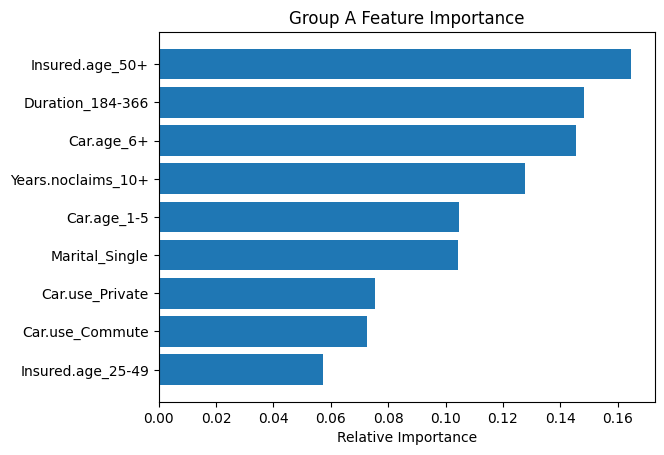

In [112]:
plt.title("Group A Feature Importance")
plt.barh(range(len(ind)), importance[ind], align="center")
plt.yticks(range(len(ind)), [features[i] for i in ind])
plt.xlabel("Relative Importance")
plt.show()

#### 1.3 Explaining Predictions

##### 1.3.1 Individual predictions explainations using LIME 

In [113]:
#Choosen to explain the 50th entry
choosen_instance = group_A_X_test_copy.iloc[[50]]

In [115]:
#Creating the Explainer
predict_model = lambda x: group_A_model.predict(x)

explainer = lime.lime_tabular.LimeTabularExplainer(group_A_X_train.values,feature_names = group_A_X_train.columns,mode='regression')
exp = explainer.explain_instance(choosen_instance.values[0], predict_model)
exp.show_in_notebook(show_all=False)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


##### 1.3.2 Individual predictions explainations using Shapley 

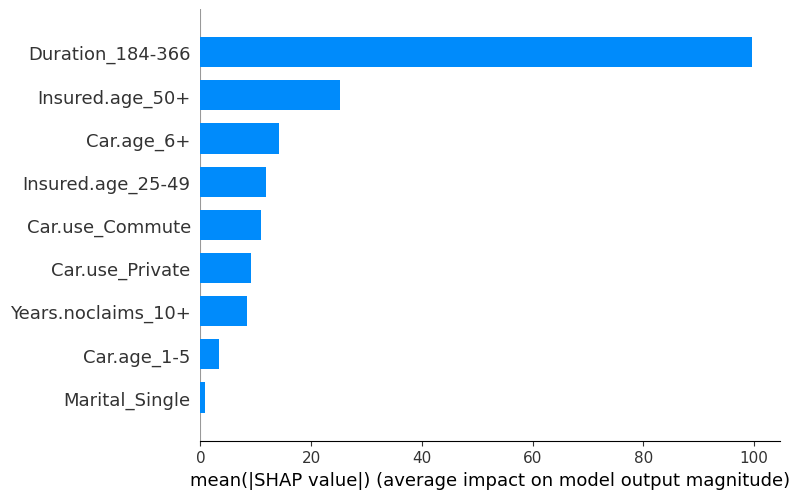

In [116]:
explainer = shap.TreeExplainer(group_A_model,masker=shap.maskers.Impute(data=group_A_X_train))
#Using the explainer to explain predictions
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.summary_plot(shap_values, group_A_X_train, plot_type="bar")

### 2. Group B: Enhanced Pricing Features

#### 2.1 Data Management and Preliminary Analysis

In [117]:
group_B_y = group_B['AMT_Claim']
group_B_X = group_B.drop(['AMT_Claim', 'Territory'], axis=1)

In [118]:
group_B_X

Duration  Insured.age  Car.age  Years.noclaims  Marital_Single  \
0           366           45       -1              25               0   
1           182           44        3              20               0   
2           184           48        6              14               0   
3           183           71        6              43               0   
4           183           84       10              65               0   
...         ...          ...      ...             ...             ...   
99995       182           61       10              42               1   
99996       192           48        3              32               0   
99997       184           50        2              31               1   
99998       184           76        2              58               0   
99999       365           25        2               7               1   

       Car.use_Commute  Car.use_Farmer  Car.use_Private  Region_Urban  \
0                    1               0                0             1   
1                    1               0                0             1   
2                    1               0                0             1   
3                    0               0                1             1   
4                    0               0                1             1   
...                ...             ...              ...           ...   
99995                0               0                1             1   
99996                1               0                0             1   
99997                1               0                0             0   
99998                0               0                1             0   
99999                0               0                0             0   

       Credit.score  Annual.miles.drive  
0             609.0             6213.71  
1             575.0            12427.42  
2             847.0            12427.42  
3             842.0             6213.71  
4             856.0             6213.71  
...             ...                 ...  
99995         824.0             6213.71  
99996         850.0            12427.42  
99997         650.0             6213.71  
99998         811.0             6213.71  
99999         818.0            12427.42  

[100000 rows x 11 columns]

We apply bucketing to `Duration`, `Insured.age`, `Years.noclaims`, `Credit.score`, and `Annual.miles.drive` to make narrower risk groupings than Group A:

In [119]:
group_B_X['Duration'] = pd.cut(group_B_X['Duration'], bins=[0, 183, 366], labels=["0-183", "184-366"])
group_B_X['Insured.age'] = pd.cut(group_B_X['Insured.age'], bins=[0, 24, 49, 110], labels=["0-24", "25-49", "50+"])
group_B_X['Years.noclaims'] = pd.cut(group_B_X['Years.noclaims'], bins=[0, 19, 81], labels=["0-9", "10+"])
group_B_X['Car.age'] = pd.cut(group_B_X['Car.age'], bins=[-2, 1, 5, 20], labels=["new", "1-5", "6+"])

<Axes: xlabel='Credit.score', ylabel='Count'>

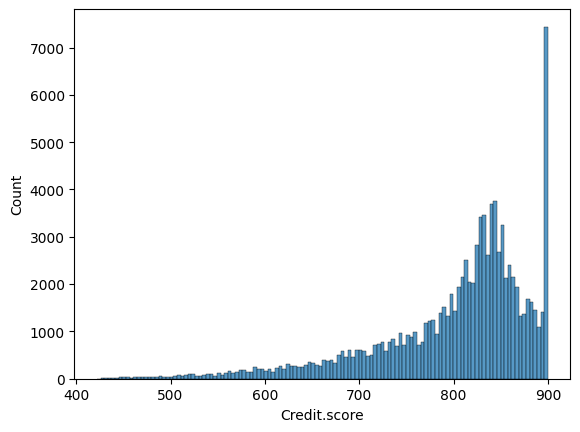

In [120]:
sns.histplot(group_B_X['Credit.score'])

In [121]:
group_B_X['Credit.score'] = pd.cut(group_B_X['Credit.score'], bins=[400, 700, 850, 901], labels=["400-699", "700-849", "850+"])

In [122]:
group_B_X['Annual.miles.drive'].describe()

count    100000.000000
mean       9124.122908
std        3826.144730
min           0.000000
25%        6213.710000
50%        7456.452000
75%       12427.420000
max       56731.172300
Name: Annual.miles.drive, dtype: float64

<Axes: xlabel='Annual.miles.drive', ylabel='Count'>

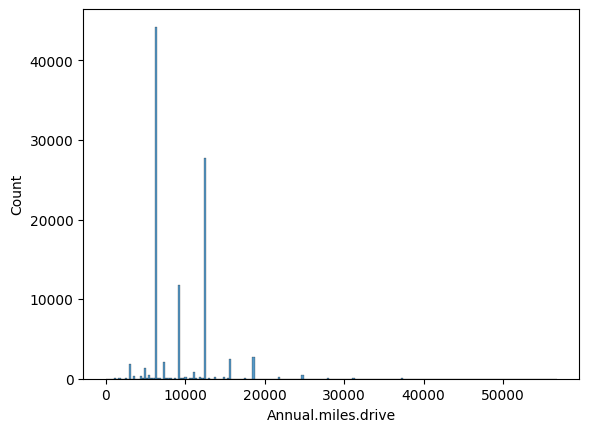

In [123]:
sns.histplot(group_B_X['Annual.miles.drive'])

In [124]:
group_B_X['Annual.miles.drive'] = pd.cut(group_B_X['Annual.miles.drive'], bins=[0, 7500, 12500, 60000], labels=["0-7499", "7500-12499", "12500+"])

We now convert the categorical features we created into dummy variables, dropping the first as a base line.

In [125]:
group_B_X = pd.get_dummies(group_B_X, drop_first=True)

In [126]:
group_B_X

Marital_Single  Car.use_Commute  Car.use_Farmer  Car.use_Private  \
0                   0                1               0                0   
1                   0                1               0                0   
2                   0                1               0                0   
3                   0                0               0                1   
4                   0                0               0                1   
...               ...              ...             ...              ...   
99995               1                0               0                1   
99996               0                1               0                0   
99997               1                1               0                0   
99998               0                0               0                1   
99999               1                0               0                0   

       Region_Urban  Duration_184-366  Insured.age_25-49  Insured.age_50+  \
0                 1                 1                  1                0   
1                 1                 0                  1                0   
2                 1                 1                  1                0   
3                 1                 0                  0                1   
4                 1                 0                  0                1   
...             ...               ...                ...              ...   
99995             1                 0                  0                1   
99996             1                 1                  1                0   
99997             0                 1                  0                1   
99998             0                 1                  0                1   
99999             0                 1                  1                0   

       Car.age_1-5  Car.age_6+  Years.noclaims_10+  Credit.score_700-849  \
0                0           0                   1                     0   
1                1           0                   1                     0   
2                0           1                   0                     1   
3                0           1                   1                     1   
4                0           1                   1                     0   
...            ...         ...                 ...                   ...   
99995            0           1                   1                     1   
99996            1           0                   1                     1   
99997            1           0                   1                     0   
99998            1           0                   1                     1   
99999            1           0                   0                     1   

       Credit.score_850+  Annual.miles.drive_7500-12499  \
0                      0                              0   
1                      0                              1   
2                      0                              1   
3                      0                              0   
4                      1                              0   
...                  ...                            ...   
99995                  0                              0   
99996                  0                              1   
99997                  0                              0   
99998                  0                              0   
99999                  0                              1   

       Annual.miles.drive_12500+  
0                              0  
1                              0  
2                              0  
3                              0  
4                              0  
...                          ...  
99995                          0  
99996                          0  
99997                          0  
99998                          0  
99999                          0  

[100000 rows x 15 columns]

The number of unique risk groups are as follows:

In [127]:
exposure_size_B = group_B_X.groupby(group_B_X.columns.tolist(),as_index=False).size()

In [128]:
exposure_size_B

Marital_Single  Car.use_Commute  Car.use_Farmer  Car.use_Private  \
0                  0                0               0                0   
1                  0                0               0                0   
2                  0                0               0                0   
3                  0                0               0                0   
4                  0                0               0                0   
...              ...              ...             ...              ...   
1990               1                1               0                0   
1991               1                1               0                0   
1992               1                1               0                0   
1993               1                1               0                0   
1994               1                1               0                0   

      Region_Urban  Duration_184-366  Insured.age_25-49  Insured.age_50+  \
0                0                 0                  0                1   
1                0                 0                  0                1   
2                0                 0                  0                1   
3                0                 0                  0                1   
4                0                 0                  0                1   
...            ...               ...                ...              ...   
1990             1                 1                  1                0   
1991             1                 1                  1                0   
1992             1                 1                  1                0   
1993             1                 1                  1                0   
1994             1                 1                  1                0   

      Car.age_1-5  Car.age_6+  Years.noclaims_10+  Credit.score_700-849  \
0               0           0                   0                     1   
1               0           0                   1                     0   
2               0           0                   1                     1   
3               0           1                   1                     0   
4               0           1                   1                     0   
...           ...         ...                 ...                   ...   
1990            1           0                   1                     0   
1991            1           0                   1                     0   
1992            1           0                   1                     1   
1993            1           0                   1                     1   
1994            1           0                   1                     1   

      Credit.score_850+  Annual.miles.drive_7500-12499  \
0                     0                              1   
1                     1                              0   
2                     0                              1   
3                     0                              0   
4                     1                              0   
...                 ...                            ...   
1990                  1                              0   
1991                  1                              1   
1992                  0                              0   
1993                  0                              0   
1994                  0                              1   

      Annual.miles.drive_12500+  size  
0                             0     1  
1                             1     4  
2                             0     1  
3                             1     2  
4                             1     1  
...                         ...   ...  
1990                          1     5  
1991                          0    63  
1992                          0   178  
1993                          1    76  
1994                          0   364  

[1995 rows x 16 columns]

In [129]:
len(exposure_size_B)

1995

In [130]:
exposure_size_B.describe()

Marital_Single  Car.use_Commute  Car.use_Farmer  Car.use_Private  \
count     1995.000000      1995.000000     1995.000000      1995.000000   
mean         0.463158         0.409023        0.100251         0.329825   
std          0.498766         0.491777        0.300409         0.470267   
min          0.000000         0.000000        0.000000         0.000000   
25%          0.000000         0.000000        0.000000         0.000000   
50%          0.000000         0.000000        0.000000         0.000000   
75%          1.000000         1.000000        0.000000         1.000000   
max          1.000000         1.000000        1.000000         1.000000   

       Region_Urban  Duration_184-366  Insured.age_25-49  Insured.age_50+  \
count   1995.000000       1995.000000        1995.000000      1995.000000   
mean       0.553383          0.636090           0.454637         0.452130   
std        0.497267          0.481244           0.498063         0.497828   
min        0.000000          0.000000           0.000000         0.000000   
25%        0.000000          0.000000           0.000000         0.000000   
50%        1.000000          1.000000           0.000000         0.000000   
75%        1.000000          1.000000           1.000000         1.000000   
max        1.000000          1.000000           1.000000         1.000000   

       Car.age_1-5   Car.age_6+  Years.noclaims_10+  Credit.score_700-849  \
count  1995.000000  1995.000000         1995.000000           1995.000000   
mean      0.337845     0.376441            0.532832              0.410526   
std       0.473094     0.484614            0.499046              0.492053   
min       0.000000     0.000000            0.000000              0.000000   
25%       0.000000     0.000000            0.000000              0.000000   
50%       0.000000     0.000000            1.000000              0.000000   
75%       1.000000     1.000000            1.000000              1.000000   
max       1.000000     1.000000            1.000000              1.000000   

       Credit.score_850+  Annual.miles.drive_7500-12499  \
count        1995.000000                    1995.000000   
mean            0.333333                       0.403008   
std             0.471523                       0.490625   
min             0.000000                       0.000000   
25%             0.000000                       0.000000   
50%             0.000000                       0.000000   
75%             1.000000                       1.000000   
max             1.000000                       1.000000   

       Annual.miles.drive_12500+         size  
count                1995.000000  1995.000000  
mean                    0.242607    50.125313  
std                     0.428767   152.026879  
min                     0.000000     1.000000  
25%                     0.000000     3.000000  
50%                     0.000000     8.000000  
75%                     0.000000    31.500000  
max                     1.000000  2740.000000

<Axes: xlabel='size', ylabel='Count'>

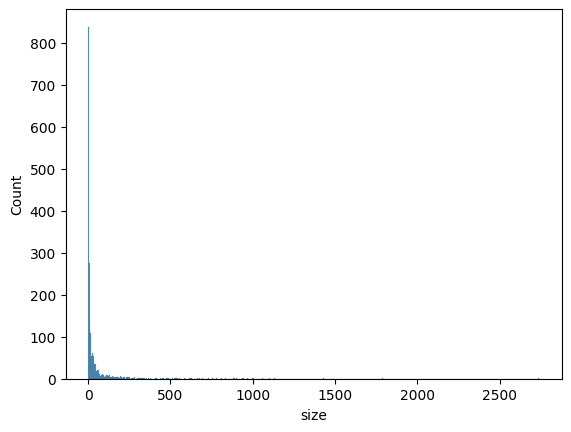

In [131]:
sns.histplot(exposure_size_B['size'])

#### 2.2 Model Building and Predictions

In [132]:
group_B_X_train, group_B_X_test, group_B_y_train, group_B_y_test = train_test_split(group_B_X, group_B_y, train_size=0.7, random_state=1)
group_B_model = HistGradientBoostingRegressor(max_iter=1000, l2_regularization=True, random_state=1, verbose=0, early_stopping=True)
group_B_model.fit(group_B_X_train, group_B_y_train)
group_B_y_pred = group_B_model.predict(group_B_X_test)
group_B_final = group_B_X_test
group_B_final["risk_premium"] = group_B_y_pred
group_B_final["actual_claim"] = group_B_y_test
group_B_final['risk_premium'].describe()

count    30000.000000
mean       140.479438
std        141.889746
min         14.338673
25%         69.453178
50%        109.802100
75%        182.852471
max       1815.554948
Name: risk_premium, dtype: float64

In [133]:
group_B_final.sort_values(by=["risk_premium"], ascending=False)

Marital_Single  Car.use_Commute  Car.use_Farmer  Car.use_Private  \
21521               1                1               0                0   
1264                1                1               0                0   
78675               1                1               0                0   
88785               1                1               0                0   
38596               1                1               0                0   
...               ...              ...             ...              ...   
29937               0                1               0                0   
32943               1                0               0                1   
81089               1                0               0                1   
44759               1                0               0                1   
67611               1                0               0                1   

       Region_Urban  Duration_184-366  Insured.age_25-49  Insured.age_50+  \
21521             1                 1                  0                0   
1264              1                 1                  0                0   
78675             1                 1                  0                0   
88785             1                 1                  0                0   
38596             1                 1                  0                0   
...             ...               ...                ...              ...   
29937             1                 0                  1                0   
32943             1                 0                  0                1   
81089             1                 0                  0                1   
44759             1                 0                  0                1   
67611             1                 0                  0                1   

       Car.age_1-5  Car.age_6+  Years.noclaims_10+  Credit.score_700-849  \
21521            0           0                   0                     0   
1264             0           0                   0                     0   
78675            0           0                   0                     0   
88785            0           0                   0                     0   
38596            0           0                   0                     0   
...            ...         ...                 ...                   ...   
29937            1           0                   1                     1   
32943            0           0                   0                     1   
81089            0           0                   0                     1   
44759            0           0                   0                     1   
67611            0           0                   0                     1   

       Credit.score_850+  Annual.miles.drive_7500-12499  \
21521                  0                              1   
1264                   0                              1   
78675                  0                              1   
88785                  0                              1   
38596                  0                              1   
...                  ...                            ...   
29937                  0                              0   
32943                  0                              0   
81089                  0                              0   
44759                  0                              1   
67611                  0                              1   

       Annual.miles.drive_12500+  risk_premium  actual_claim  
21521                          0   1815.554948   8235.667972  
1264                           0   1815.554948      0.000000  
78675                          0   1815.554948  13619.748045  
88785                          0   1815.554948      0.000000  
38596                          0   1815.554948      0.000000  
...                          ...           ...           ...  
29937                          0     14.820842      0.000000  
32943                          0     14.338673      0.0

In [134]:
group_B_X_train, group_B_X_test, group_B_y_train, group_B_y_test = train_test_split(group_B_X, group_B_y, train_size=0.7, random_state=1)
group_B_X_test_copy  = group_B_X_test.copy()

In [135]:
group_B_model = RandomForestRegressor(n_estimators=5000, n_jobs=12)
group_B_model.fit(group_B_X_train, group_B_y_train)

RandomForestRegressor(n_estimators=5000, n_jobs=12)

In [136]:
group_B_y_pred = group_B_model.predict(group_B_X_test)

In [137]:
group_B_final = group_B_X_test

In [138]:
group_B_final["risk_premium"] = group_B_y_pred
group_B_final["actual_claim"] = group_B_y_test

In [139]:
group_B_final

Marital_Single  Car.use_Commute  Car.use_Farmer  Car.use_Private  \
43660               0                0               0                1   
87278               0                0               0                1   
14317               0                0               0                1   
81932               0                0               0                1   
95321               1                0               0                1   
...               ...              ...             ...              ...   
994                 0                1               0                0   
42287               0                0               0                1   
4967                1                1               0                0   
47725               0                0               0                1   
42348               0                1               0                0   

       Region_Urban  Duration_184-366  Insured.age_25-49  Insured.age_50+  \
43660             1                 0                  0                1   
87278             1                 1                  0                1   
14317             1                 1                  0                1   
81932             0                 0                  1                0   
95321             1                 1                  0                1   
...             ...               ...                ...              ...   
994               1                 1                  0                1   
42287             1                 1                  1                0   
4967              1                 1                  1                0   
47725             1                 1                  0                1   
42348             1                 1                  0                1   

       Car.age_1-5  Car.age_6+  Years.noclaims_10+  Credit.score_700-849  \
43660            0           1                   0                     1   
87278            0           1                   1                     0   
14317            0           1                   1                     1   
81932            0           0                   1                     0   
95321            0           1                   1                     0   
...            ...         ...                 ...                   ...   
994              0           1                   0                     1   
42287            0           0                   0                     1   
4967             1           0                   0                     0   
47725            0           1                   1                     0   
42348            0           1                   1                     0   

       Credit.score_850+  Annual.miles.drive_7500-12499  \
43660                  0                              1   
87278                  1                              0   
14317                  0                              0   
81932                  1                              1   
95321                  1                              0   
...                  ...                            ...   
994                    0                              1   
42287                  0                              0   
4967                   0                              1   
47725                  1                              0   
42348                  1                              0   

       Annual.miles.drive_12500+  risk_premium  actual_claim  
43660                          0      0.000000      0.000000  
87278                          0     29.759267      0.000000  
14317                          0     65.215435      0.000000  
81932                          0      0.000000      0.000000  
95321                          0     17.479437      0.000000  
...                          ...           ...           ...  
994                            0    129.779822      0.000000  
42287                          0    260.092350      0.0

In [140]:
group_B_final['risk_premium'].describe()

count    30000.000000
mean       141.306973
std        264.997743
min          0.000000
25%         12.674329
50%         73.950063
75%        169.998732
max       8206.532571
Name: risk_premium, dtype: float64

<Axes: xlabel='risk_premium', ylabel='Count'>

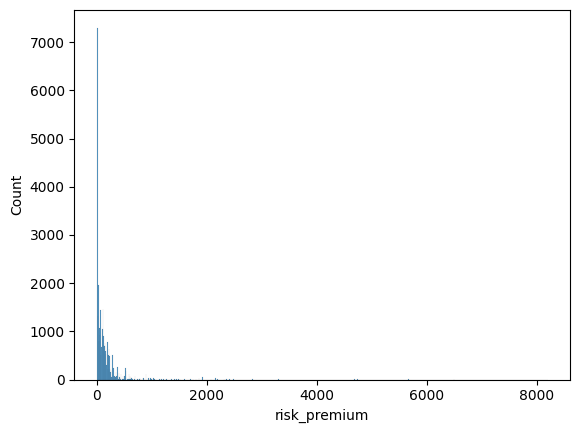

In [141]:
sns.histplot(group_B_final["risk_premium"])

In [142]:
mean_absolute_error(group_B_y_pred, group_B_y_test)

247.4900985929374

In [143]:
group_B_final.sort_values(by=["risk_premium"], ascending=False)

Marital_Single  Car.use_Commute  Car.use_Farmer  Car.use_Private  \
53130               0                0               0                0   
98311               0                1               0                0   
7817                0                1               0                0   
85839               1                0               0                0   
30836               1                0               0                0   
...               ...              ...             ...              ...   
89252               1                1               0                0   
3385                0                0               0                1   
19014               0                0               0                1   
60376               0                0               1                0   
43660               0                0               0                1   

       Region_Urban  Duration_184-366  Insured.age_25-49  Insured.age_50+  \
53130             1                 1                  1                0   
98311             0                 1                  0                0   
7817              0                 1                  0                0   
85839             1                 1                  1                0   
30836             1                 1                  1                0   
...             ...               ...                ...              ...   
89252             1                 1                  0                1   
3385              0                 1                  1                0   
19014             0                 1                  1                0   
60376             1                 1                  0                1   
43660             1                 0                  0                1   

       Car.age_1-5  Car.age_6+  Years.noclaims_10+  Credit.score_700-849  \
53130            0           0                   1                     0   
98311            1           0                   0                     0   
7817             1           0                   0                     0   
85839            0           0                   0                     0   
30836            0           0                   0                     0   
...            ...         ...                 ...                   ...   
89252            0           1                   0                     1   
3385             0           0                   1                     0   
19014            0           1                   0                     1   
60376            0           1                   1                     1   
43660            0           1                   0                     1   

       Credit.score_850+  Annual.miles.drive_7500-12499  \
53130                  0                              0   
98311                  0                              0   
7817                   0                              0   
85839                  0                              0   
30836                  0                              0   
...                  ...                            ...   
89252                  0                              1   
3385                   0                              0   
19014                  0                              1   
60376                  0                              0   
43660                  0                              1   

       Annual.miles.drive_12500+  risk_premium  actual_claim  
53130                          0   8206.532571   8304.621097  
98311                          0   6499.892029      0.000000  
7817                           0   6499.892029   9361.280273  
85839                          1   5668.855741      0.000000  
30836                          1   5668.855741      0.000000  
...                          ...           ...           ...  
89252                          0      0.000000      0.000000  
3385                           0      0.000000      0.0

In [144]:
features = group_B_X_train.columns
importance = group_B_model.feature_importances_
ind_top = np.argsort(importance)[len(features)-10:]
ind_bottom = np.argsort(importance)[:10]

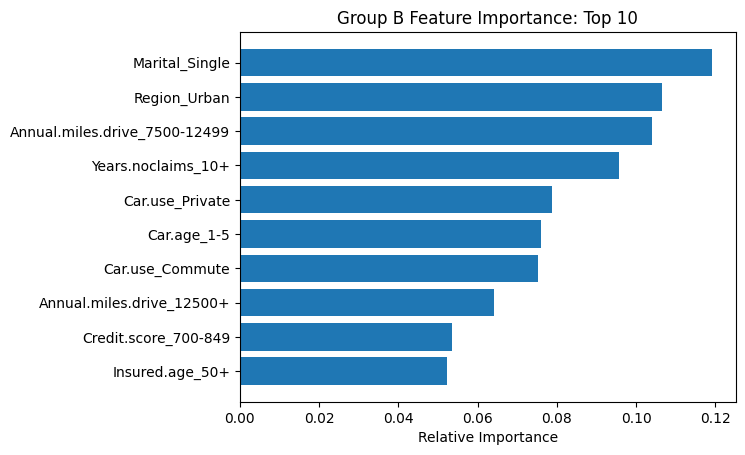

In [145]:
plt.title("Group B Feature Importance: Top 10")
plt.barh(range(len(ind_top)), importance[ind_top], align="center")
plt.yticks(range(len(ind_top)), [features[i] for i in ind_top])
plt.xlabel("Relative Importance")
plt.show()

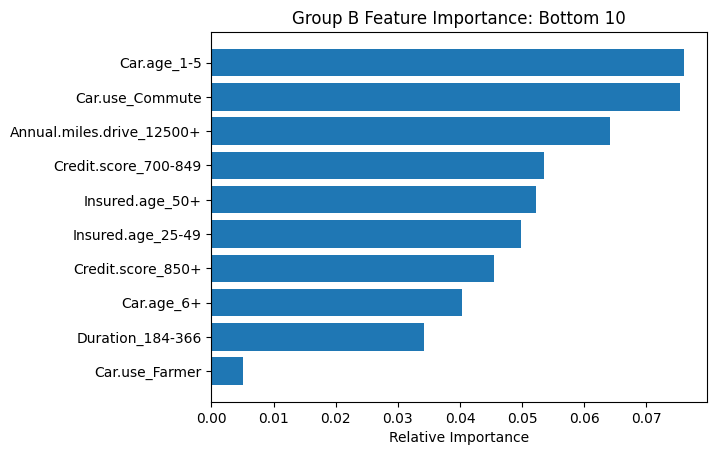

In [146]:
plt.title("Group B Feature Importance: Bottom 10")
plt.barh(range(len(ind_bottom)), importance[ind_bottom], align="center")
plt.yticks(range(len(ind_bottom)), [features[i] for i in ind_bottom])
plt.xlabel("Relative Importance")
plt.show()

#### 2.3 Explaining Predictions

##### 2.3.1 Individual predictions explainations using LIME 

In [149]:
#Choosen to explain the 50th entry
choosen_instance = group_B_X_test_copy.iloc[[50]]

In [150]:
#Creating the Explainer
predict_model = lambda x: group_B_model.predict(x)
explainer = lime.lime_tabular.LimeTabularExplainer(group_B_X_train.values,feature_names = group_B_X_train.columns,mode='regression')
exp = explainer.explain_instance(choosen_instance.values[0], predict_model)
exp.show_in_notebook(show_all=False)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


##### 2.3.2 Individual predictions explainations using Shapley 

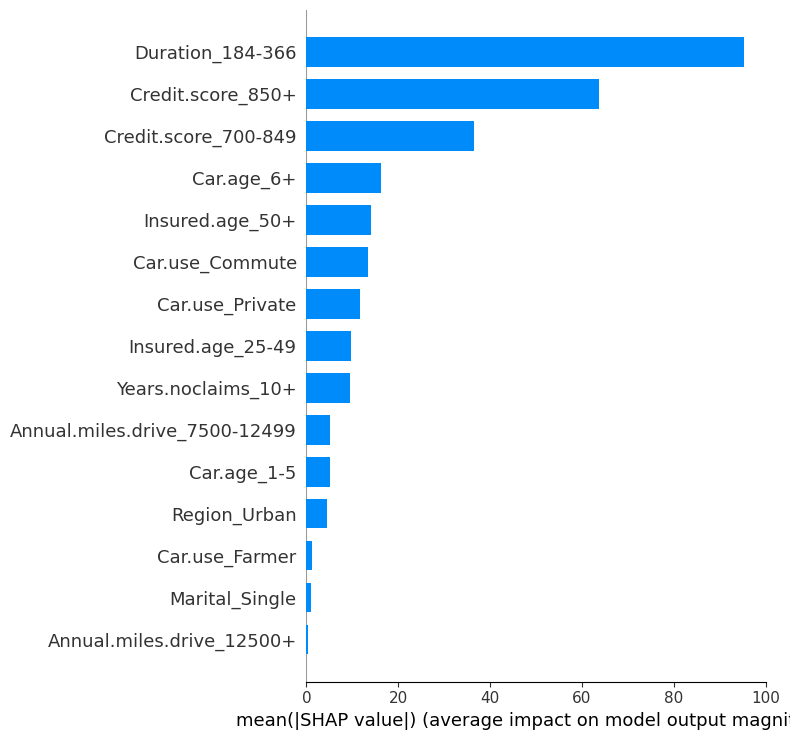

In [152]:
explainer = shap.TreeExplainer(group_B_model,masker=shap.maskers.Impute(data=group_B_X_train))
#Using the explainer to explain predictions
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.summary_plot(shap_values, group_B_X_train, plot_type="bar")

### 3. Group C: Individual Risk Assessment

#### 3.1 Data Management and Preliminary Analysis

In [153]:
group_C_y = group_C['AMT_Claim']
group_C_X = group_C.drop(['AMT_Claim', 'Territory'], axis=1)

_We can add a low-variance filter here if we wish to include Territory back in._

In [154]:
#group_C_X['Territory'] = group_C_X['Territory'].astype('category')

In [155]:
group_C_X = pd.get_dummies(group_C_X, drop_first=True)

In [156]:
group_C_X

Duration  Insured.age  Car.age  Credit.score  Annual.miles.drive  \
0           366           45       -1         609.0             6213.71   
1           182           44        3         575.0            12427.42   
2           184           48        6         847.0            12427.42   
3           183           71        6         842.0             6213.71   
4           183           84       10         856.0             6213.71   
...         ...          ...      ...           ...                 ...   
99995       182           61       10         824.0             6213.71   
99996       192           48        3         850.0            12427.42   
99997       184           50        2         650.0             6213.71   
99998       184           76        2         811.0             6213.71   
99999       365           25        2         818.0            12427.42   

       Years.noclaims  Annual.pct.driven  Total.miles.driven  Pct.drive.mon  \
0                  25           0.849315         8864.376247       0.148070   
1                  20           0.465753         8092.308208       0.147686   
2                  14           0.520548         3225.832512       0.153735   
3                  43           0.065753          253.024528       0.106702   
4                  65           0.441096         4374.379634       0.123807   
...               ...                ...                 ...            ...   
99995              42           0.161644          903.231641       0.068358   
99996              32           0.167123         2870.045192       0.160821   
99997              31           0.117808          935.538222       0.095132   
99998              58           0.473973         4287.600459       0.106783   
99999               7           0.421918         6131.406302       0.107360   

       Pct.drive.tue  ...  Right.turn.intensity08  Right.turn.intensity09  \
0           0.152466  ...                     3.0                     1.0   
1           0.136917  ...                  1099.0                   615.0   
2           0.097124  ...                     0.0                     0.0   
3           0.056437  ...                     0.0                     0.0   
4           0.169661  ...                   325.0                   111.0   
...              ...  ...                     ...                     ...   
99995       0.110253  ...                     4.0                     4.0   
99996       0.124073  ...                   357.0                   175.0   
99997       0.076684  ...                     3.0                     0.0   
99998       0.151199  ...                     6.0                     1.0   
99999       0.220392  ...                   389.0                   165.0   

       Right.turn.intensity10  Right.turn.intensity11  Right.turn.intensity12  \
0                         0.0                     0.0                     0.0   
1                       219.0                   101.0                    40.0   
2                         0.0                     0.0                     0.0   
3                         0.0                     0.0                     0.0   
4                        18.0                     4.0                     2.0   
...                       ...                     ...                     ...   
99995                     0.0                     0.0                     0.0   
99996                    48.0                    22.0                    11.0   
99997                     0.0                     0.0                     0.0   
99998                     0.0                     0.0                     0.0   
99999                    31.0                    12.0                     9.0   

       Marital_Single  Car.use_Commute  Car.use_Farmer  Car.use_Private  \
0                   0                1               0                0   
1                   0                1               0                0   
2                   0             

In [157]:
def min_max_scale(x):
    return((x-x.min())/(x.max()-x.min()))

In [158]:
for feat in group_C_X.columns:
    group_C_X[str(feat)] = min_max_scale(group_C_X[str(feat)])

#### 3.2 Model Building and Predictions

In [179]:
group_C_X_train, group_C_X_test, group_C_y_train, group_C_y_test = train_test_split(group_C_X, group_C_y, train_size=0.7, random_state=1)
group_C_model = HistGradientBoostingRegressor(max_iter=1000, l2_regularization=True, random_state=1, verbose=1, early_stopping=True)
group_C_model.fit(group_C_X_train, group_C_y_train)
group_C_y_pred = group_C_model.predict(group_C_X_test)

Binning 0.025 GB of training data: 0.365 s
Binning 0.003 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 9, train loss: 827342.56075, val loss: 869316.03487, in 0.025s
[2/1000] 1 tree, 31 leaves, max depth = 9, train loss: 811734.83406, val loss: 856753.87362, in 0.021s
[3/1000] 1 tree, 31 leaves, max depth = 10, train loss: 797637.55592, val loss: 853664.18397, in 0.022s
[4/1000] 1 tree, 31 leaves, max depth = 10, train loss: 783560.18704, val loss: 843892.35345, in 0.018s
[5/1000] 1 tree, 31 leaves, max depth = 10, train loss: 771660.65452, val loss: 835757.76404, in 0.023s
[6/1000] 1 tree, 31 leaves, max depth = 12, train loss: 759959.46608, val loss: 823579.56001, in 0.019s
[7/1000] 1 tree, 31 leaves, max depth = 9, train loss: 749032.48169, val loss: 815781.67938, in 0.018s
[8/1000] 1 tree, 31 leaves, max depth = 10, train loss: 739328.43717, val loss: 811540.39939, in 0.020s
[9/1000] 1 tree, 31 leaves, max depth = 10, train 

In [180]:
group_C_final = group_C_X_test
group_C_final["risk_premium"] = group_C_y_pred
group_C_final["actual_claim"] = group_C_y_test
group_C_final['risk_premium'].describe()

count    30000.000000
mean       148.431058
std        485.083189
min      -3729.467816
25%         -1.819777
50%         40.000971
75%        136.516144
max      18496.705433
Name: risk_premium, dtype: float64

In [181]:
group_C_final.sort_values(by=["risk_premium"], ascending=False)

Duration  Insured.age   Car.age  Credit.score  Annual.miles.drive  \
93340  1.000000     0.402299  0.227273      0.274059            0.219058   
83589  0.997050     0.333333  0.045455      0.780335            0.219058   
20209  1.000000     0.356322  0.227273      0.387029            0.219058   
58133  0.917404     0.333333  0.227273      0.414226            0.219058   
9638   1.000000     0.206897  0.454545      0.292887            0.197152   
...         ...          ...       ...           ...                 ...   
55932  0.973451     0.655172  0.636364      0.125523            0.219058   
76629  1.000000     0.310345  0.045455      0.587866            0.109529   
41610  1.000000     0.379310  0.500000      0.359833            0.109529   
75463  0.997050     0.471264  0.590909      0.177824            0.164294   
71247  0.997050     0.344828  0.500000      0.332636            0.219058   

       Years.noclaims  Annual.pct.driven  Total.miles.driven  Pct.drive.mon  \
93340        0.329114           0.920330            0.208473       0.136009   
83589        0.329114           0.516484            0.106864       0.132397   
20209        0.367089           0.491758            0.132329       0.112624   
58133        0.341772           0.486264            0.131479       0.123087   
9638         0.075949           0.942308            0.341988       0.151590   
...               ...                ...                 ...            ...   
55932        0.670886           0.978022            0.044568       0.105843   
76629        0.075949           0.065934            0.000256       0.091163   
41610        0.367089           0.016484            0.003426       0.108938   
75463        0.329114           0.016484            0.000534       0.009455   
71247        0.316456           0.074176            0.007142       0.134540   

       Pct.drive.tue  ...  Right.turn.intensity10  Right.turn.intensity11  \
93340       0.158344  ...                0.000049                0.000013   
83589       0.126292  ...                0.000013                0.000005   
20209       0.110516  ...                0.000210                0.000088   
58133       0.116391  ...                0.000229                0.000107   
9638        0.181731  ...                0.000114                0.000038   
...              ...  ...                     ...                     ...   
55932       0.093353  ...                0.000390                0.000132   
76629       0.181779  ...                0.000001                0.000000   
41610       0.131916  ...                0.000719                0.000460   
75463       0.229096  ...                0.000000                0.000000   
71247       0.124702  ...                0.000000                0.000000   

       Right.turn.intensity12  Marital_Single  Car.use_Commute  \
93340                0.000002             0.0              1.0   
83589                0.000000             0.0              1.0   
20209                0.000039             0.0              1.0   
58133                0.000052             0.0              1.0   
9638                 0.000014             0.0              1.0   
...                       ...             ...              ...   
55932                0.000048             1.0              1.0   
76629                0.000000             0.0              1.0   
41610                0.000215             0.0              1.0   
75463                0.000000             1.0              0.0   
71247                0.000000             0.0              1.0   

       Car.use_Farmer  Car.use_Private  Region_Urban  risk_premium  \
93340             0.0              0.0           1.0  18496.705433   
83589             0.0              0.0           1.0  18312.504218   
20209             0.0              0.0           1.0  16600.136401   
58133             0.0              0.0           1.0  12293.187601   
9638              0.0              0.0           1.0  11669.994094   
...    

In [163]:
group_C_X_train, group_C_X_test, group_C_y_train, group_C_y_test = train_test_split(group_C_X, group_C_y, train_size=0.7, random_state=1)
group_C_X_test_copy  = group_C_X_test.copy()

In [164]:
group_C_model = RandomForestRegressor(n_estimators=1000, n_jobs=12)
group_C_model.fit(group_C_X_train, group_C_y_train)

RandomForestRegressor(n_estimators=1000, n_jobs=12)

In [165]:
group_C_y_pred = group_C_model.predict(group_C_X_test)

In [182]:
_, group_C_final, _, _ = train_test_split(group_C.drop(['AMT_Claim'], axis=1), group_C['AMT_Claim'], train_size=0.7, random_state=1)

In [183]:
group_C_final

Duration  Insured.age  Car.age  Credit.score  Annual.miles.drive  \
43660       180           61        7         836.0           12427.420   
87278       347           54        8         861.0            6213.710   
14317       185           52        7         827.0            6213.710   
81932       182           48        1         896.0           12427.420   
95321       366           60        9         898.0            6213.710   
...         ...          ...      ...           ...                 ...   
994         366           51        9         773.0            9320.565   
42287       366           44        1         715.0            6213.710   
4967        365           27        5         637.0           12427.420   
47725       365           67        6         878.0            6213.710   
42348       209           53        6         863.0            6213.710   

       Years.noclaims  Territory  Annual.pct.driven  Total.miles.driven  \
43660              18         73           0.550685         2158.380457   
87278              38         80           0.764384         1701.653774   
14317              36         88           0.564384         6016.248769   
81932              31         38           0.079452         1319.218323   
95321              38         85           0.901370         4126.631349   
...               ...        ...                ...                 ...   
994                 1         87           1.000000        18682.764336   
42287              17         30           0.460274         1972.419411   
4967                9         35           0.021918          446.074877   
47725              47         35           0.369863         5216.051290   
42348              36         87           0.575342         5037.548740   

       Pct.drive.mon  ...  Right.turn.intensity08  Right.turn.intensity09  \
43660       0.140579  ...                   139.0                    51.0   
87278       0.141999  ...                  3121.0                  2158.0   
14317       0.151236  ...                  1291.0                   617.0   
81932       0.083554  ...                    70.0                    21.0   
95321       0.132276  ...                    18.0                     6.0   
...              ...  ...                     ...                     ...   
994         0.137865  ...                   665.0                   362.0   
42287       0.149147  ...                  2457.0                  1530.0   
4967        0.168096  ...                    39.0                    16.0   
47725       0.122856  ...                   134.0                    74.0   
42348       0.155140  ...                   674.0                   275.0   

       Right.turn.intensity10  Right.turn.intensity11  Right.turn.intensity12  \
43660                     1.0                     0.0                     0.0   
87278                  1100.0                   605.0                   291.0   
14317                   143.0                    48.0                     9.0   
81932                     0.0                     0.0                     0.0   
95321                     0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
994                     125.0                    50.0                    19.0   
42287                   682.0                   377.0                   200.0   
4967                     15.0                     0.0                     0.0   
47725                    22.0                     8.0                     1.0   
42348                    45.0                    10.0                     0.0   

       Marital_Single  Car.use_Commute  Car.use_Farmer  Car.use_Private  \
43660               0                0               0                1   
87278               0                0               0                1   
14317               0                0               0                1   
81932  

In [168]:
group_A_final

Marital_Single  Car.use_Commute  Car.use_Private  Duration_184-366  \
43660               0                0                1                 0   
87278               0                0                1                 1   
14317               0                0                1                 1   
81932               0                0                1                 0   
95321               1                0                1                 1   
...               ...              ...              ...               ...   
994                 0                1                0                 1   
42287               0                0                1                 1   
4967                1                1                0                 1   
47725               0                0                1                 1   
42348               0                1                0                 1   

       Insured.age_25-49  Insured.age_50+  Car.age_1-5  Car.age_6+  \
43660                  0                1            0           1   
87278                  0                1            0           1   
14317                  0                1            0           1   
81932                  1                0            0           0   
95321                  0                1            0           1   
...                  ...              ...          ...         ...   
994                    0                1            0           1   
42287                  1                0            0           0   
4967                   1                0            1           0   
47725                  0                1            0           1   
42348                  0                1            0           1   

       Years.noclaims_10+  risk_premium  actual_claim  
43660                   0     35.334413      0.000000  
87278                   1     63.094034      0.000000  
14317                   1     63.094034      0.000000  
81932                   1      0.000000      0.000000  
95321                   1     72.866797      0.000000  
...                   ...           ...           ...  
994                     0    195.793883      0.000000  
42287                   0    344.337074      0.000000  
4967                    0    251.231502      0.000000  
47725                   1     63.094034    114.529449  
42348                   1     85.907407      0.000000  

[30000 rows x 11 columns]

In [169]:
group_B_final

Marital_Single  Car.use_Commute  Car.use_Farmer  Car.use_Private  \
43660               0                0               0                1   
87278               0                0               0                1   
14317               0                0               0                1   
81932               0                0               0                1   
95321               1                0               0                1   
...               ...              ...             ...              ...   
994                 0                1               0                0   
42287               0                0               0                1   
4967                1                1               0                0   
47725               0                0               0                1   
42348               0                1               0                0   

       Region_Urban  Duration_184-366  Insured.age_25-49  Insured.age_50+  \
43660             1                 0                  0                1   
87278             1                 1                  0                1   
14317             1                 1                  0                1   
81932             0                 0                  1                0   
95321             1                 1                  0                1   
...             ...               ...                ...              ...   
994               1                 1                  0                1   
42287             1                 1                  1                0   
4967              1                 1                  1                0   
47725             1                 1                  0                1   
42348             1                 1                  0                1   

       Car.age_1-5  Car.age_6+  Years.noclaims_10+  Credit.score_700-849  \
43660            0           1                   0                     1   
87278            0           1                   1                     0   
14317            0           1                   1                     1   
81932            0           0                   1                     0   
95321            0           1                   1                     0   
...            ...         ...                 ...                   ...   
994              0           1                   0                     1   
42287            0           0                   0                     1   
4967             1           0                   0                     0   
47725            0           1                   1                     0   
42348            0           1                   1                     0   

       Credit.score_850+  Annual.miles.drive_7500-12499  \
43660                  0                              1   
87278                  1                              0   
14317                  0                              0   
81932                  1                              1   
95321                  1                              0   
...                  ...                            ...   
994                    0                              1   
42287                  0                              0   
4967                   0                              1   
47725                  1                              0   
42348                  1                              0   

       Annual.miles.drive_12500+  risk_premium  actual_claim  
43660                          0      0.000000      0.000000  
87278                          0     29.759267      0.000000  
14317                          0     65.215435      0.000000  
81932                          0      0.000000      0.000000  
95321                          0     17.479437      0.000000  
...                          ...           ...           ...  
994                            0    129.779822      0.000000  
42287                          0    260.092350      0.0

In [171]:
group_C_final[['risk_premium_A', 'risk_premium_B', 'risk_premium_C']].describe()

KeyError: "None of [Index(['risk_premium_A', 'risk_premium_B', 'risk_premium_C'], dtype='object')] are in the [columns]"

<Axes: ylabel='risk_premium_A'>

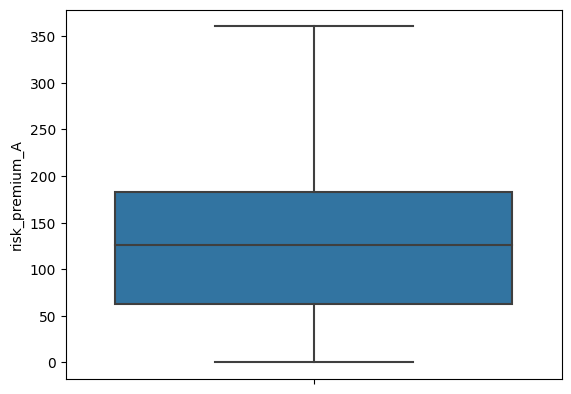

In [ ]:
sns.boxplot(data=group_C_final, y='risk_premium_A', showfliers=False)

<Axes: ylabel='risk_premium_B'>

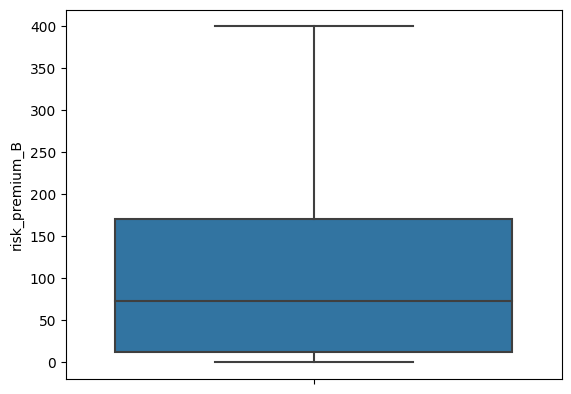

In [ ]:
sns.boxplot(data=group_C_final, y='risk_premium_B', showfliers=False)

<Axes: ylabel='risk_premium_C'>

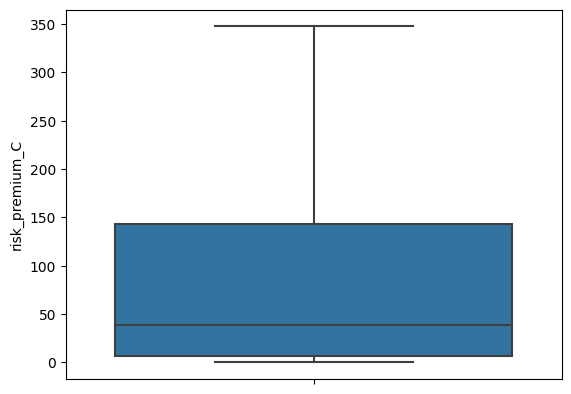

In [ ]:
sns.boxplot(data=group_C_final, y='risk_premium_C', showfliers=False)

<Axes: xlabel='risk_premium_A', ylabel='Count'>

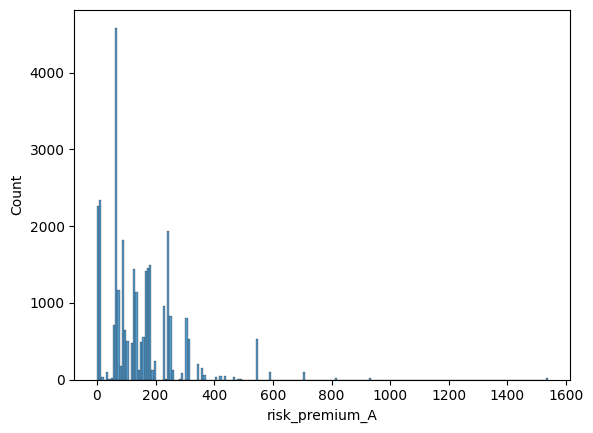

In [ ]:
sns.histplot(group_C_final["risk_premium_A"])

<Axes: xlabel='risk_premium_B', ylabel='Count'>

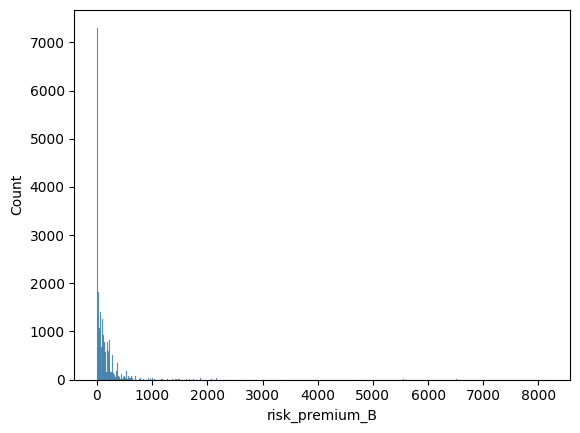

In [ ]:
sns.histplot(group_C_final["risk_premium_B"])

<Axes: xlabel='risk_premium_C', ylabel='Count'>

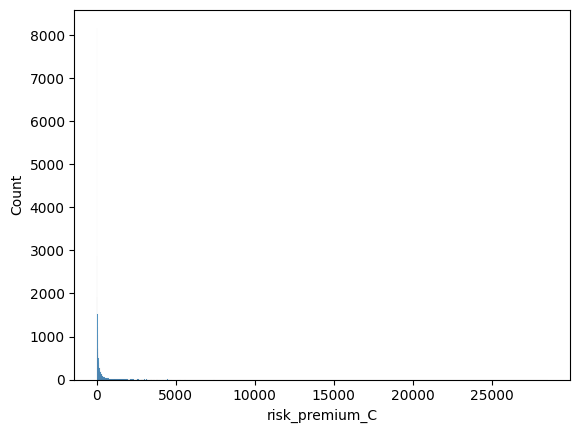

In [ ]:
sns.histplot(group_C_final["risk_premium_C"])

In [ ]:
mean_absolute_error(group_C_y_pred, group_C_y_test)

218.39084825459005

In [ ]:
group_C_final.sort_values(by=["risk_premium_A"], ascending=False)

Duration  Insured.age  Car.age  Credit.score  Annual.miles.drive  \
38056       360           20        0         787.0          12427.4200   
6317        366           23        0         613.0           6213.7100   
6210        366           24       -1         667.0           6213.7100   
84071       366           20       -1         808.0          12427.4200   
62989       366           22       -1         739.0           6213.7100   
...         ...          ...      ...           ...                 ...   
23310       182           75        2         842.0           6213.7100   
2000        181           67       12         763.0           6213.7100   
10490       227           46        6         784.0          15037.1782   
4277        183           42        7         876.0          21747.9850   
90197       183           45        2         900.0           6213.7100   

       Years.noclaims  Territory  Annual.pct.driven  Total.miles.driven  \
38056               3         85           0.076712         1158.238567   
6317                2         87           0.983562        11469.889849   
6210                4         85           0.619178         7458.906273   
84071               4         66           0.947945        12948.859195   
62989               4         59           0.101370         1164.884954   
...               ...        ...                ...                 ...   
23310              30         38           0.178082          421.612713   
2000               50         36           0.487671         1794.990622   
10490              24         73           0.638356         5337.805535   
4277               25         78           0.490411         8320.598136   
90197              19         73           0.468493         3625.840476   

       Pct.drive.mon  ...  Right.turn.intensity12  Marital_Single  \
38056       0.124993  ...                    13.0               1   
6317        0.165521  ...                    79.0               1   
6210        0.114206  ...                     0.0               1   
84071       0.142501  ...                     0.0               1   
62989       0.131161  ...                     0.0               1   
...              ...  ...                     ...             ...   
23310       0.162803  ...                     0.0               1   
2000        0.215981  ...                     0.0               0   
10490       0.115202  ...                   204.0               1   
4277        0.130146  ...                    17.0               0   
90197       0.165831  ...                     0.0               0   

       Car.use_Commute  Car.use_Farmer  Car.use_Private  Region_Urban  \
38056                0               0                1             0   
6317                 0               0                1             0   
6210                 0               0                1             1   
84071                0               0                1             1   
62989                0               0                1             1   
...                ...             ...              ...           ...   
23310                0               0                1             1   
2000                 0               1                0             0   
10490                0               0                0             1   
4277                 1               0                0             1   
90197                0               0                1             1   

       risk_premium_A  risk_premium_B  risk_premium_C  actual_claim  
38056     1537.801022       32.092716      242.237130       0.00000  
6317      1537.801022       71.749992     1546.235035       0.00000  
6210      1537.801022       42.152525     2490.937860    6034.40625  
84071     1537.801022       23.506556     1317.602293       0.00000  
62989     1537.801022     2338.566985       11.369120       0.00000  
...               ...             ...             ...           ...  
23310    

In [172]:
features = group_C_X_train.columns
importance = group_C_model.feature_importances_
ind_top = np.argsort(importance)[len(features)-10:]
ind_bottom = np.argsort(importance)[:10]

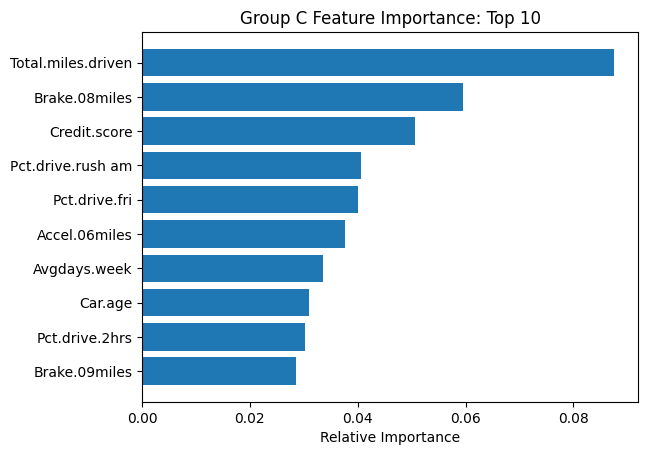

In [173]:
plt.title("Group C Feature Importance: Top 10")
plt.barh(range(len(ind_top)), importance[ind_top], align="center")
plt.yticks(range(len(ind_top)), [features[i] for i in ind_top])
plt.xlabel("Relative Importance")
plt.show()

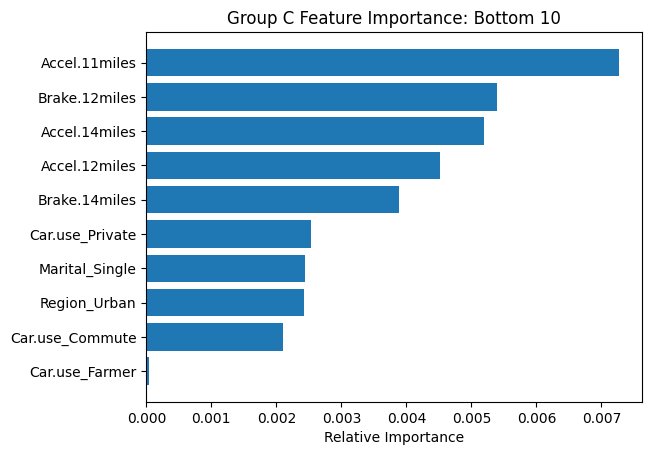

In [ ]:
plt.title("Group C Feature Importance: Bottom 10")
plt.barh(range(len(ind_bottom)), importance[ind_bottom], align="center")
plt.yticks(range(len(ind_bottom)), [features[i] for i in ind_bottom])
plt.xlabel("Relative Importance")
plt.show()

Explanations to follow which isolate those whose risk premiums altered dramatically in order to determine **why**, and is this **equitable**?

#### 3.3 Explaining Predictions

##### 3.3.1 Individual predictions explainations using LIME 

In [174]:
#Choosen to explain the 50th entry
choosen_instance = group_C_X_test_copy.iloc[[50]]

In [177]:
#Creating the Explainer
predict_model =  lambda x: group_C_model.predict(x)
explainer = lime.lime_tabular.LimeTabularExplainer(group_C_X_train.values,feature_names = group_C_X_train.columns,class_names= ['risk premium'],mode='regression')
exp = explainer.explain_instance(choosen_instance.values[0], predict_model)
exp.show_in_notebook(show_all=False)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


##### 3.3.2 Individual predictions explainations using Shapley 

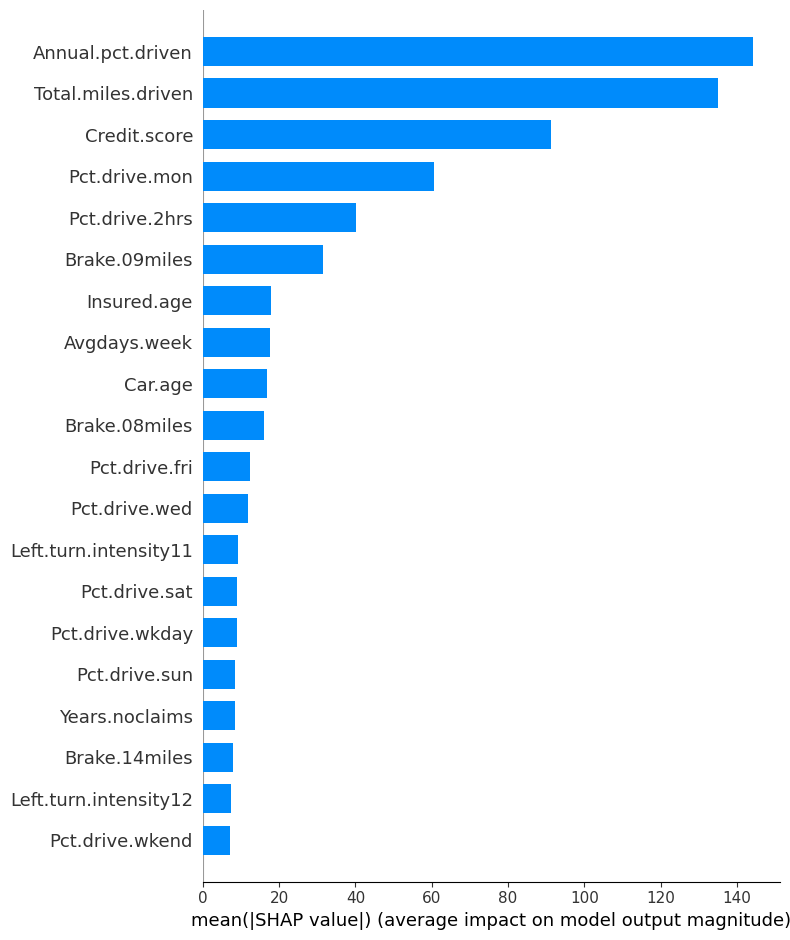

In [178]:
explainer = shap.TreeExplainer(group_C_model,masker=shap.maskers.Impute(data=group_C_X_train))
#Using the explainer to explain predictions
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.summary_plot(shap_values, group_C_X_train, plot_type="bar")